## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [33]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, PrecisionRecallDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

pd.set_option('future.no_silent_downcasting', True)

In [3]:
def train_val_test_split(X, y, pct_splits, random_state):
    X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=pct_splits[-1], random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=pct_splits[1]/(sum(pct_splits[:2])), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
s = """'age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y'"""

desired_columns = re.findall("'(.*?)'", s)

df = (
    pd.read_csv('/home/jeff/Downloads/zoomcamp_hw_3/bank-full.csv',sep=';')
    .loc[:,desired_columns]
    .replace({'y':{'yes':1, 'no':0}})
    .astype({'y':int})
)

X = df.drop('y', axis=1)
y = df.loc[:,'y']
pct_splits = [0.6, 0.2, 0.2]

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, pct_splits, random_state=42)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

**Answer:** duration has highest AUC (0.72)

In [5]:
numeric_columns = (
    X_train
    .select_dtypes('number')
    .columns
    .tolist()
)

result_l = []

for col in numeric_columns:
    y_score = (
        X_train.loc[:,col] > X_train.loc[:,col].mean()
    )

    auc = roc_auc_score(y_train, y_score)
    auc = max([auc, 1-auc]) #flips AUC if it's < 0.50
    
    result_l.append({'feature':col, 'roc_auc_score':auc})

(
    pd.DataFrame(result_l)
    .sort_values('roc_auc_score', ascending=False)
)

,feature,roc_auc_score
3,duration,0.719325
6,previous,0.601682
5,pdays,0.599853
1,balance,0.552432
4,campaign,0.545798
2,day,0.529042
0,age,0.507619


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [6]:
#tbh I don't understand why we need to use a DictVectorizer, I'm gonna just use a OHE

model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
        remainder='passthrough',
        force_int_remainder_cols=False
    ),
    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'contact', 'month',
                                                   'poutcome'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [7]:
roc_auc_score(y_val, model.predict(X_val))

np.float64(0.6610087408734309)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

**Answer:** precision == recall at threshold around 0.265

In [28]:
df_precision_recall = pd.DataFrame(
    {
        'y_actual':y_val,
         'y_prob':model.predict_proba(X_val)[:,1],
    }
)

result_l = []

for threshold in np.arange(0,1,0.01):
    df_precision_recall = (
        df_precision_recall
        .assign(
            y_predicted = lambda x:x['y_prob'] >= threshold
        )
    )

    precision = (
        df_precision_recall
        .query("y_predicted == True")
        .loc[:,'y_actual']
        .mean()
    )

    recall = (
        df_precision_recall
        .query("y_actual == True")
        .loc[:,'y_predicted']
        .mean()
    )

    result_l.append({'threshold':threshold, 'precision':precision, 'recall':recall})

df_precision_recall_summary = pd.DataFrame(result_l)

(
    df_precision_recall_summary
    .assign(
        delta = lambda x:np.abs(x['precision'] - x['recall'])
    )
    .sort_values('delta', ascending=True)
    .head()
)
#minimum around 0.28

,threshold,precision,recall,delta
28,0.28,0.572368,0.569159,0.003210
27,0.27,0.567273,0.583178,0.015905
29,0.29,0.572674,0.552336,0.020338
26,0.26,0.561788,0.599065,0.037278
30,0.30,0.579798,0.536449,0.043349


#### or can do with sklearn builtin functions

In [91]:
precision, recall, threshold = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1])

df_prt = pd.DataFrame({'precision':precision,'recall':recall, 'threshold':np.concatenate([[0], threshold])})
df_prt.head()

,precision,recall,threshold
0,0.118337,1.0,0.000000
1,0.118350,1.0,0.000138
2,0.118363,1.0,0.000153
3,0.118376,1.0,0.000178
4,0.118389,1.0,0.000457


<Axes: >

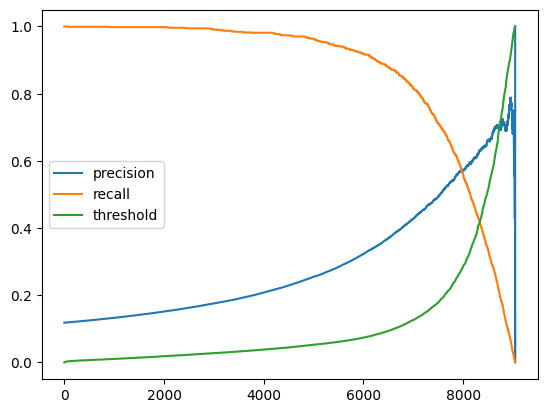

In [90]:
(
    df_prt
    .plot()
)

In [92]:
import plotly.express as px

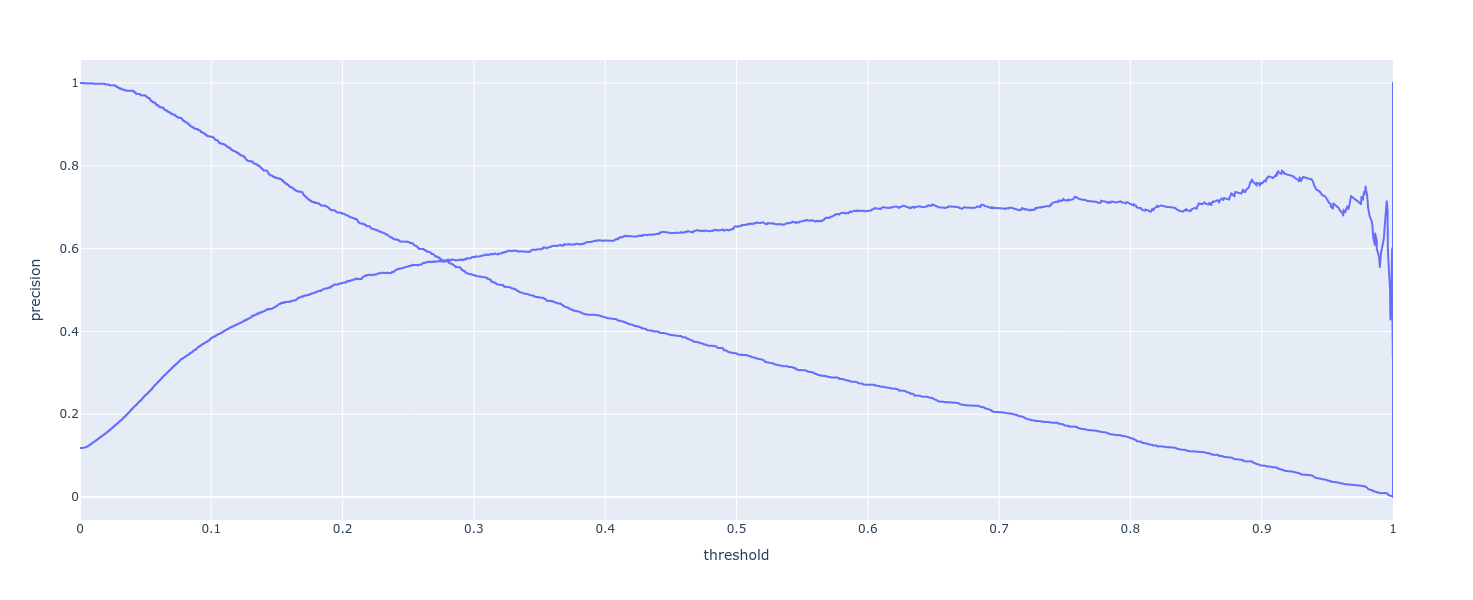

In [97]:
fig = px.line(df_prt, x='threshold', y='precision', height=600, width=600)
fig.add_trace(px.line(df_prt, x='threshold', y='recall').data[0])
fig.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

**Answer:** F1 is max around threshold == 0.22

In [29]:
(
    df_precision_recall_summary
    .assign(
        f1 = lambda x:2 * ((x['precision'] * x['recall']))/(x['precision'] + x['recall'])
    )
    .sort_values('f1', ascending=False)
    .head()
)

#F1 is maximum at threshold around 0.21

,threshold,precision,recall,f1
21,0.21,0.526007,0.671028,0.589733
22,0.22,0.536398,0.654206,0.589474
20,0.20,0.516949,0.684112,0.588898
19,0.19,0.506449,0.697196,0.586709
23,0.23,0.541568,0.639252,0.586369


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

**Answer:** The closest option is 0.006, I get 0.0035

In [48]:
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
        remainder='passthrough',
        force_int_remainder_cols=False
    ),
    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

result_l = []

for train_ind, test_ind in kf.split(X_full_train, y_full_train):
    model.fit(X_full_train.iloc[train_ind], y_full_train.iloc[train_ind])
    result_l.append(roc_auc_score(y_val, model.predict(X_val)))

print(np.array(result_l).std())

0.003457473219967255


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [54]:
result_l = []

for C in [0.01, 0.1, 0.5, 10]:
    
    model = make_pipeline(
        make_column_transformer(
            (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
            remainder='passthrough',
            force_int_remainder_cols=False
        ),
        LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    )

    inner_result_l = []
    
    for train_ind, test_ind in kf.split(X_full_train, y_full_train):
        model.fit(X_full_train.iloc[train_ind], y_full_train.iloc[train_ind])
        inner_result_l.append(roc_auc_score(y_val, model.predict(X_val)))

    inner_result_a = np.array(inner_result_l)
    result_l.append({'C':C, 'mean_scores':inner_result_a.mean(), 'std_scores':inner_result_a.std()})

In [57]:
(
    pd.DataFrame(result_l)
    .sort_values('mean_scores', ascending=False)
)

,C,mean_scores,std_scores
2,0.50,0.659371,0.001624
3,10.00,0.658966,0.003713
1,0.10,0.656134,0.001309
0,0.01,0.634675,0.003273


#### what a mess, let's use gridsearch

In [70]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
        remainder='passthrough',
        force_int_remainder_cols=False
    ),
    LogisticRegression(solver='liblinear', max_iter=1000)
)

from sklearn.model_selection import GridSearchCV

params = {'logisticregression__C':[0.01, 0.1, 0.5, 10]}

model_gs = GridSearchCV(model, params, n_jobs=-1)

model_gs.fit(X_full_train, y_full_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 0.5, 10]})

In [71]:
model_gs.best_params_

{'logisticregression__C': 10}

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw04
* If your answer doesn't match options exactly, select the closest one